In [1]:
import sys
# if "google.colab" in str(get_ipython()):
! {sys.executable} -m pip install pytorch-lifestream
! {sys.executable} -m pip install catboost
! {sys.executable} -m pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.1 MB/s eta 0:00:0000:0100:01
  Created wheel for pytorch-lifestream: filename=pytorch_lifestream

In [2]:
from functools import partial
from datetime import timedelta, datetime

import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import catboost

import torch
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from ptls.nn import TrxEncoder
from ptls.nn.seq_encoder.rnn_encoder import RnnEncoder
from ptls.frames import PtlsDataModule
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames.coles.multimodal_dataset import MultiModalDataset
from ptls.frames.coles.multimodal_dataset import MultiModalIterableDataset
from ptls.frames.coles.multimodal_dataset import MultiModalSortTimeSeqEncoderContainer
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceDataset
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceIterableDataset
from ptls.frames.inference_module import InferenceModuleMultimodal
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load import IterableProcessingDataset
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.datasets import MemoryMapDataset
from ptls.preprocessing import PandasDataPreprocessor

2025-05-10 16:03:09.986967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746892990.202905      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746892990.268157      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# from datasets import load_dataset
import pandas as pd

df = pd.read_csv("hf://datasets/dllllb/rosbank-churn/train.csv.gz")

In [4]:
df

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.00,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.00,C2C_OUT,0,0.0
...,...,...,...,...,...,...,...,...,...,...
490508,01/04/2017,10176,6011,type1,810,24APR17:14:05:26,600.00,WD_ATM_ROS,1,405.0
490509,01/06/2017,10171,5411,type1,810,06JUN17:00:00:00,132.00,POS,0,0.0
490510,01/02/2017,10167,5541,type1,810,03FEB17:00:00:00,1000.00,POS,1,280428.2
490511,01/06/2017,10163,5941,type1,810,08JUN17:00:00:00,100.00,POS,0,0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


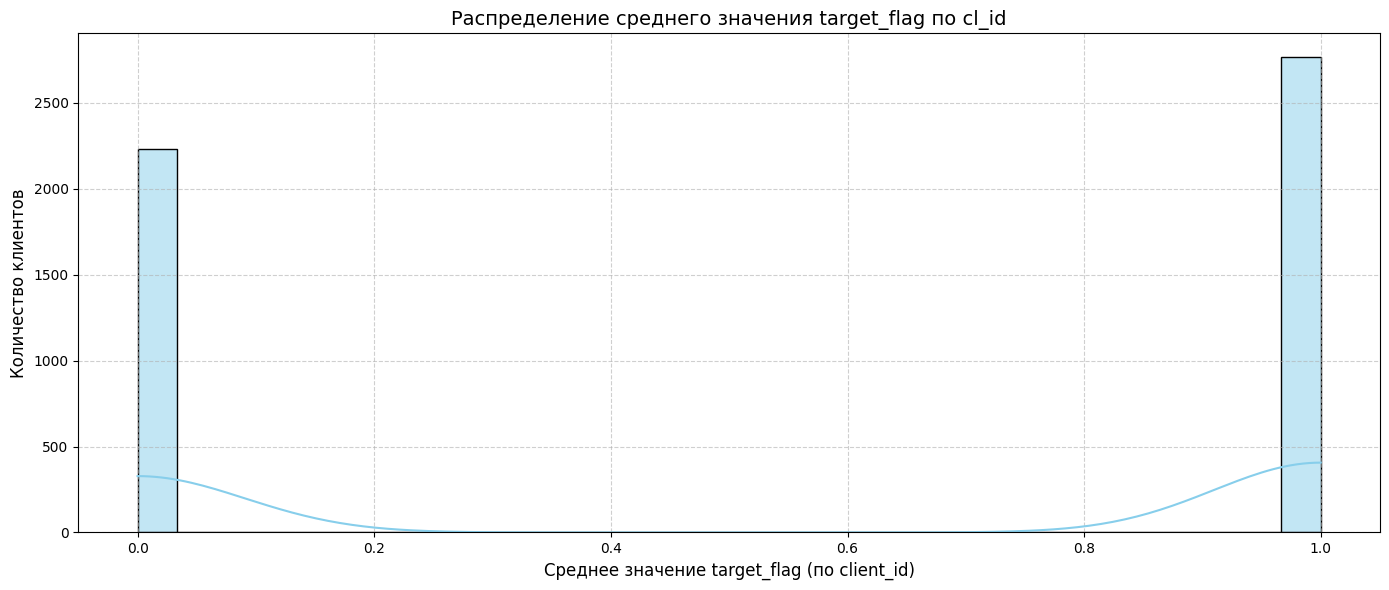

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cl_target_dist = df.groupby("cl_id")["target_flag"].mean().sort_values()

plt.figure(figsize=(14, 6))
sns.histplot(cl_target_dist, bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title("Распределение среднего значения target_flag по cl_id", fontsize=14)
plt.xlabel("Среднее значение target_flag (по client_id)", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Распределение target_flag по всем событиям')

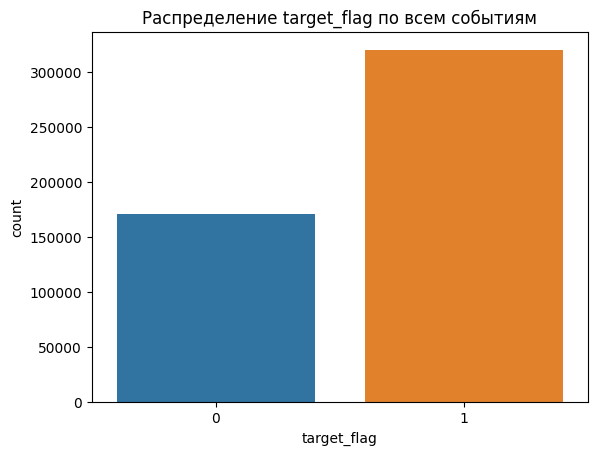

In [6]:
sns.countplot(data=df, x="target_flag")
plt.title("Распределение target_flag по всем событиям")


In [7]:
for col in ["MCC", "channel_type", "currency", "trx_category"]:
    print(f"{col}: {df[f'{col}'].explode().nunique()} уникальных значений")


MCC: 344 уникальных значений
channel_type: 5 уникальных значений
currency: 59 уникальных значений
trx_category: 10 уникальных значений


In [8]:
mcc_flag = df[["MCC", "cl_id", "target_flag"]]
mcc_flag = mcc_flag.groupby("cl_id").agg({"MCC": lambda x: list(x), "target_flag": "mean"})
mcc_flag["target_flag_bin"] = (mcc_flag["target_flag"] > 0.5).astype(int)

from collections import Counter
from itertools import chain

for flag in [0, 1]:
    all_mccs = list(chain.from_iterable(mcc_flag[mcc_flag["target_flag_bin"] == flag]["MCC"]))
    most_common = Counter(all_mccs).most_common(10)
    print(f"\nTop MCC codes for target_flag={flag}:")
    for mcc, count in most_common:
        print(f"  MCC: {mcc}, count: {count}")



Top MCC codes for target_flag=0:
  MCC: 5411, count: 46297
  MCC: 6011, count: 18858
  MCC: 5814, count: 11066
  MCC: 5499, count: 9324
  MCC: 5812, count: 8286
  MCC: 5541, count: 7200
  MCC: 5912, count: 6752
  MCC: 6012, count: 4347
  MCC: 5999, count: 3902
  MCC: 5921, count: 2808

Top MCC codes for target_flag=1:
  MCC: 5411, count: 75343
  MCC: 6011, count: 35524
  MCC: 5814, count: 30285
  MCC: 5812, count: 21741
  MCC: 5499, count: 17913
  MCC: 5541, count: 12616
  MCC: 5912, count: 11976
  MCC: 5999, count: 9171
  MCC: 5921, count: 5770
  MCC: 6012, count: 5709


In [9]:
print(df["target_flag"].value_counts(normalize=True))


target_flag
1    0.652588
0    0.347412
Name: proportion, dtype: float64


In [10]:
df['PERIOD']

0         01/10/2017
1         01/10/2017
2         01/12/2017
3         01/10/2017
4         01/10/2017
             ...    
490508    01/04/2017
490509    01/06/2017
490510    01/02/2017
490511    01/06/2017
490512    01/06/2017
Name: PERIOD, Length: 490513, dtype: object

In [11]:
for col in df.columns:
    print(col, df[col].isna().sum())

PERIOD 0
cl_id 0
MCC 0
channel_type 2910
currency 0
TRDATETIME 0
amount 0
trx_category 0
target_flag 0
target_sum 0


In [12]:
df = df.dropna().reset_index(drop=True)

In [13]:
n_cutomers = len(pd.unique(df["cl_id"]))

print("n_cutomers:", n_cutomers)

n_cutomers: 4975


In [14]:
for col in df.columns:
    print(col, df[col].isna().sum())

PERIOD 0
cl_id 0
MCC 0
channel_type 0
currency 0
TRDATETIME 0
amount 0
trx_category 0
target_flag 0
target_sum 0


In [15]:
df["period_ym"] = pd.to_datetime(df["PERIOD"], format="%d/%m/%Y").dt.strftime("%Y%m")

In [16]:
sourceA_columns = ["cl_id", "TRDATETIME", "MCC", "channel_type", "currency", "trx_category"]
sourceB_columns = ["cl_id", "TRDATETIME", "amount", "period_ym"]

sourceA = df[sourceA_columns].copy()
sourceB = df[sourceB_columns].copy()

In [17]:
sourceA

,cl_id,TRDATETIME,MCC,channel_type,currency,trx_category
0,50,14JUL17:06:53:13,4829,type5,810,C2C_IN
1,50,15SEP17:00:00:00,5411,type5,810,POS
2,50,24SEP17:00:00:00,5812,type5,810,POS
3,50,08JUL17:00:00:00,5661,type5,810,POS
4,50,08JUL17:00:00:00,5732,type5,810,POS
...,...,...,...,...,...,...
487598,10176,24APR17:14:05:26,6011,type1,810,WD_ATM_ROS
487599,10171,06JUN17:00:00:00,5411,type1,810,POS
487600,10167,03FEB17:00:00:00,5541,type1,810,POS
487601,10163,08JUN17:00:00:00,5941,type1,810,POS


In [18]:
sourceB

,cl_id,TRDATETIME,amount,period_ym
0,50,14JUL17:06:53:13,40000.00,201707
1,50,15SEP17:00:00:00,2373.00,201709
2,50,24SEP17:00:00:00,5955.00,201709
3,50,08JUL17:00:00:00,5599.00,201707
4,50,08JUL17:00:00:00,29600.00,201707
...,...,...,...,...
487598,10176,24APR17:14:05:26,600.00,201704
487599,10171,06JUN17:00:00:00,132.00,201706
487600,10167,03FEB17:00:00:00,1000.00,201702
487601,10163,08JUN17:00:00:00,100.00,201706


In [19]:
sourceA_drop_indices = np.random.choice(sourceA.index, int(130000/4084151 * len(sourceA)), replace=False)
sourceB_drop_indices = np.random.choice(sourceB.index, int(420000/4084151 * len(sourceB)), replace=False)

sourceA = sourceA.drop(sourceA_drop_indices).reset_index(drop=True)
sourceB = sourceB.drop(sourceB_drop_indices).reset_index(drop=True)

In [20]:
sourceA

,cl_id,TRDATETIME,MCC,channel_type,currency,trx_category
0,50,14JUL17:06:53:13,4829,type5,810,C2C_IN
1,50,15SEP17:00:00:00,5411,type5,810,POS
2,50,24SEP17:00:00:00,5812,type5,810,POS
3,50,08JUL17:00:00:00,5661,type5,810,POS
4,50,08JUL17:00:00:00,5732,type5,810,POS
...,...,...,...,...,...,...
472078,10176,24APR17:14:05:26,6011,type1,810,WD_ATM_ROS
472079,10171,06JUN17:00:00:00,5411,type1,810,POS
472080,10167,03FEB17:00:00:00,5541,type1,810,POS
472081,10163,08JUN17:00:00:00,5941,type1,810,POS


In [21]:
def tr_datetime_preprocess(tr_datetime):
    dt = datetime.strptime(tr_datetime, "%d%b%y:%H:%M:%S")

    timestamp_seconds = int(dt.timestamp())
    return timestamp_seconds

In [22]:
sourceA["TRDATETIME"] = sourceA["TRDATETIME"].apply(tr_datetime_preprocess)
sourceB["TRDATETIME"] = sourceB["TRDATETIME"].apply(tr_datetime_preprocess)

In [23]:
sourceB['period_ym'] = sourceB['period_ym'].astype(int)

In [24]:
sourceA_preprocessor = PandasDataPreprocessor(
    col_id="cl_id",
    col_event_time="TRDATETIME",
    event_time_transformation="none",
    cols_category=["MCC", "channel_type", "currency", "trx_category"],
    return_records=False,
)

sourceB_preprocessor = PandasDataPreprocessor(
    col_id="cl_id",
    col_event_time="TRDATETIME",
    event_time_transformation="none",
    cols_numerical=["period_ym", "amount"],
    return_records=False,
)

In [25]:
processed_sourceA = sourceA_preprocessor.fit_transform(sourceA)
processed_sourceB = sourceB_preprocessor.fit_transform(sourceB)

In [26]:
processed_sourceA.columns = [
    "sourceA_" + str(col) if str(col) != "cl_id" else str(col)
    for col in processed_sourceA.columns
]

In [27]:
processed_sourceB.columns = [
    "sourceB_" + str(col) if str(col) != "cl_id" else str(col)
    for col in processed_sourceB.columns
]

In [28]:
processed_sourceB

,cl_id,sourceB_TRDATETIME,sourceB_event_time,sourceB_period_ym,sourceB_amount
0,50,"[tensor(1499472000), tensor(1499472000), tenso...","[tensor(1499472000), tensor(1499472000), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(5599., dtype=torch.float64), tensor(29..."
1,52,"[tensor(1500595200), tensor(1500854400), tenso...","[tensor(1500595200), tensor(1500854400), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(27700., dtype=torch.float64), tensor(2..."
2,54,"[tensor(1491868800), tensor(1491868800), tenso...","[tensor(1491868800), tensor(1491868800), tenso...","[tensor(201704), tensor(201704), tensor(201704...","[tensor(133.8200, dtype=torch.float64), tensor..."
3,55,"[tensor(1486339200), tensor(1486425600), tenso...","[tensor(1486339200), tensor(1486425600), tenso...","[tensor(201702), tensor(201702), tensor(201702...","[tensor(209., dtype=torch.float64), tensor(112..."
4,56,"[tensor(1484550337), tensor(1485340483), tenso...","[tensor(1484550337), tensor(1485340483), tenso...","[tensor(201701), tensor(201701), tensor(201702...","[tensor(5000., dtype=torch.float64), tensor(50..."
...,...,...,...,...,...
4965,10210,"[tensor(1476921600), tensor(1477440000), tenso...","[tensor(1476921600), tensor(1477440000), tenso...","[tensor(201610), tensor(201610), tensor(201610...","[tensor(744., dtype=torch.float64), tensor(568..."
4966,10212,"[tensor(1494374400), tensor(1494806400), tenso...","[tensor(1494374400), tensor(1494806400), tenso...","[tensor(201705), tensor(201705), tensor(201706...","[tensor(50000., dtype=torch.float64), tensor(2..."
4967,10213,"[tensor(1491941046), tensor(1491955200), tenso...","[tensor(1491941046), tensor(1491955200), tenso...","[tensor(201704), tensor(201704), tensor(201704...","[tensor(40000., dtype=torch.float64), tensor(6..."
4968,10214,"[tensor(1479340800), tensor(1479340800), tenso...","[tensor(1479340800), tensor(1479340800), tenso...","[tensor(201611), tensor(201611), tensor(201611...","[tensor(117.4300, dtype=torch.float64), tensor..."


In [29]:
for col in processed_sourceB.columns:
    print(col, processed_sourceB[col].isna().sum())

cl_id 0
sourceB_TRDATETIME 0
sourceB_event_time 0
sourceB_period_ym 0
sourceB_amount 0


In [30]:
joined_data = processed_sourceA.merge(processed_sourceB, how="outer", on="cl_id")

In [31]:
joined_data

,cl_id,sourceA_TRDATETIME,sourceA_event_time,sourceA_MCC,sourceA_channel_type,sourceA_currency,sourceA_trx_category,sourceB_TRDATETIME,sourceB_event_time,sourceB_period_ym,sourceB_amount
0,50,"[tensor(1499472000), tensor(1499472000), tenso...","[tensor(1499472000), tensor(1499472000), tenso...","[tensor(30), tensor(20), tensor(23), tensor(30...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1499472000), tensor(1499472000), tenso...","[tensor(1499472000), tensor(1499472000), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(5599., dtype=torch.float64), tensor(29..."
1,52,"[tensor(1500422400), tensor(1500595200), tenso...","[tensor(1500422400), tensor(1500595200), tenso...","[tensor(80), tensor(80), tensor(1), tensor(1),...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1500595200), tensor(1500854400), tenso...","[tensor(1500595200), tensor(1500854400), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(27700., dtype=torch.float64), tensor(2..."
2,54,"[tensor(1491868800), tensor(1491868800), tenso...","[tensor(1491868800), tensor(1491868800), tenso...","[tensor(1), tensor(3), tensor(25), tensor(22),...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(8), t...","[tensor(1491868800), tensor(1491868800), tenso...","[tensor(1491868800), tensor(1491868800), tenso...","[tensor(201704), tensor(201704), tensor(201704...","[tensor(133.8200, dtype=torch.float64), tensor..."
3,55,"[tensor(1486339200), tensor(1486425600), tenso...","[tensor(1486339200), tensor(1486425600), tenso...","[tensor(1), tensor(65), tensor(1), tensor(1), ...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1486339200), tensor(1486425600), tenso...","[tensor(1486339200), tensor(1486425600), tenso...","[tensor(201702), tensor(201702), tensor(201702...","[tensor(209., dtype=torch.float64), tensor(112..."
4,56,"[tensor(1484550337), tensor(1485340483), tenso...","[tensor(1484550337), tensor(1485340483), tenso...","[tensor(2), tensor(2), tensor(2), tensor(2), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1484550337), tensor(1485340483), tenso...","[tensor(1484550337), tensor(1485340483), tenso...","[tensor(201701), tensor(201701), tensor(201702...","[tensor(5000., dtype=torch.float64), tensor(50..."
...,...,...,...,...,...,...,...,...,...,...,...
4970,10210,"[tensor(1476921600), tensor(1477440000), tenso...","[tensor(1476921600), tensor(1477440000), tenso...","[tensor(3), tensor(1), tensor(3), tensor(19), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1476921600), tensor(1477440000), tenso...","[tensor(1476921600), tensor(1477440000), tenso...","[tensor(201610), tensor(201610), tensor(201610...","[tensor(744., dtype=torch.float64), tensor(568..."
4971,10212,"[tensor(1494374400), tensor(1494806400), tenso...","[tensor(1494374400), tensor(1494806400), tenso...","[tensor(33), tensor(33), tensor(33), tensor(2)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(2), t...","[tensor(1494374400), tensor(1494806400), tenso...","[tensor(1494374400), tensor(1494806400), tenso...","[tensor(201705), tensor(201705), tensor(201706...","[tensor(50000., dtype=torch.float64), tensor(2..."
4972,10213,"[tensor(1491941046), tensor(1491955200), tenso...","[tensor(149194

In [32]:
joined_data = joined_data.map(lambda x: torch.tensor([]) if pd.isna(x) else x)

In [33]:
all_clients = joined_data["cl_id"].unique()

clients_train_val, clients_test = train_test_split(all_clients, test_size=0.2, random_state=42)

clients_train, clients_valid = train_test_split(clients_train_val, test_size=0.1, random_state=42)

train_df = joined_data[joined_data["cl_id"].isin(clients_train)].reset_index(drop=True)
valid_df = joined_data[joined_data["cl_id"].isin(clients_valid)].reset_index(drop=True)
test_df  = joined_data[joined_data["cl_id"].isin(clients_test)].reset_index(drop=True)

train_dict = train_df.to_dict("records")
valid_dict = valid_df.to_dict("records")
test_dict  = test_df.to_dict("records")

In [34]:
source_features = {
    "sourceA": {
        "categorical": ["MCC", "channel_type", "currency", "trx_category"],
        "numeric": [],
    },
    "sourceB": {
        "categorical": [],
        "numeric": ["amount", "period_ym"],
    },
}

inf_test_data = MultiModalInferenceIterableDataset(
    data=test_dict,
    source_features=source_features,
    col_id="cl_id",
    col_time="TRDATETIME",
    source_names=("sourceA", "sourceB"),
)


In [35]:
inf_test_loader = DataLoader(
    dataset = inf_test_data,
    collate_fn = partial(inf_test_data.collate_fn, col_id="cl_id"),
    shuffle = False,
    num_workers = 0,
    batch_size = 8
)

In [36]:
inf_train_data = MultiModalInferenceIterableDataset(
    data=train_dict,
    source_features=source_features,
    col_id="cl_id",
    col_time="TRDATETIME",
    source_names=("sourceA", "sourceB"),
)


inf_train_loader = DataLoader(
    dataset = inf_train_data,
    collate_fn = partial(inf_train_data.collate_fn, col_id="cl_id"),
    shuffle = False,
    num_workers = 0,
    batch_size = 8
)

In [37]:
!git clone https://github.com/google-research/google-research.git

Cloning into 'google-research'...
remote: Enumerating objects: 93586, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 93586 (delta 14), reused 11 (delta 4), pack-reused 93543 (from 5)
Receiving objects: 100% (93586/93586), 1.08 GiB | 25.24 MiB/s, done.
Resolving deltas: 100% (58248/58248), done.
Updating files: 100% (22188/22188), done.


In [38]:
!ls google-research/graph_embedding/metrics

example.py  metrics.py	README.md


In [39]:
import sys
sys.path.append("google-research/graph_embedding/metrics")

In [40]:
from metrics import (rankme,
        coherence,
        pseudo_condition_number,
        alpha_req,
        stable_rank,
        ne_sum,
        self_clustering)

In [41]:
!pip install git+https://github.com/simonzhang00/ripser-plusplus.git

  Cloning https://github.com/simonzhang00/ripser-plusplus.git to /tmp/pip-req-build-_nmpag6k
  Running command git clone --filter=blob:none --quiet https://github.com/simonzhang00/ripser-plusplus.git /tmp/pip-req-build-_nmpag6k
  Resolved https://github.com/simonzhang00/ripser-plusplus.git to commit 30243c0c752de26d7fdf6e41f08bf7b840ca4744
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for ripserplusplus: filename=ripserplusplus-1.1.3-cp311-cp311-linux_x86_64.whl size=587999 sha256=46d75341317833ba4e2f0db4e9c1381bfc7f9978633cd4f2541bf7141e2b7b18
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbktw_kq/wheels/8e/36/b2/4ec348bcc5ffcc8ba3a3b8fb1c3091f6e6de735f1eb20ee8ea
Successfully built ripserplusplus


In [42]:
import ripserplusplus as rpp
def ripser_metric(embeddings):
    """Вычисление метрики на основе ripserplusplus."""
    start_time = time()
    
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array(embeddings)

    diagrams = rpp.run("--format point-cloud", embeddings)

    persistence_sum = sum([birth - death for birth, death in diagrams[0] if death > birth])

    elapsed_time = time() - start_time
    # print(f"Computed ripser metric in {elapsed_time:.4f} seconds")

    return persistence_sum, elapsed_time

In [43]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [44]:
def create_datasets(train_dict, valid_dict, params, source_features):
    splitter = SampleSlices(
        split_count=params["split_count"],
        cnt_min=params["cnt_min"],
        cnt_max=params["cnt_max"],
    )

    train_data = MultiModalIterableDataset(
        data=train_dict,
        splitter=splitter,
        source_features=source_features,
        col_id="cl_id",
        col_time="TRDATETIME",
        source_names=("sourceA", "sourceB"),
    )

    valid_data = MultiModalIterableDataset(
        data=valid_dict,
        splitter=splitter,
        source_features=source_features,
        col_id="cl_id",
        col_time="TRDATETIME",
        source_names=("sourceA", "sourceB"),
    )

    data_loader = PtlsDataModule(
        train_data=train_data,
        train_batch_size=params["batch_size"],
        train_num_workers=0,
        valid_data=valid_data,
    )

    return data_loader

In [45]:
from time import time
import pandas as pd
import torch

def compute_metrics(model, pl_trainer, inf_train_loader, selected_metrics=None):
    """
    Compute selected embedding quality metrics after grouping embeddings by client (cl_id).
    """
    model.eval()
    
    inference_module = InferenceModuleMultimodal(
        model=model,
        pandas_output=True,
        drop_seq_features=True,
        model_out_name="emb",
        col_id="cl_id",
    )
    inference_module.model.is_reduce_sequence = False 
    device = next(model.parameters()).device
    
    inf_test_embeddings = pd.concat(
        pl_trainer.predict(inference_module, inf_train_loader),
        axis=0,
    )

    feature_columns = [col for col in inf_test_embeddings.columns if col != "cl_id"]
    inf_test_embeddings_grouped = (
        inf_test_embeddings
        .groupby("cl_id")[feature_columns]
        .mean()
        .reset_index()
    )

    embeddings = torch.tensor(inf_test_embeddings_grouped.drop(columns=["cl_id"]).values, device=device)
    embeddings_np = embeddings.cpu().numpy().astype(np.float32)

    u, s, _ = np.linalg.svd(embeddings_np, compute_uv=True, full_matrices=False)

    available_metrics = {
        "rankme": rankme,
        "coherence": coherence,
        "pseudo_condition_number": pseudo_condition_number,
        "alpha_req": alpha_req,
        "stable_rank": stable_rank,
        "ne_sum": ne_sum,
        "self_clustering": self_clustering,
        "ripser": ripser_metric
    }

    if selected_metrics is None:
        selected_metrics = list(available_metrics.keys())
        print(f"Selected metrics: {selected_metrics}")

    metrics = {}
    times = {}

    for metric_name in selected_metrics:
        if metric_name in available_metrics:
            if metric_name == "ripser":
                metrics[metric_name], times[metric_name] = available_metrics[metric_name](embeddings_np)
            else:
                start_time = time()
                metrics[metric_name] = available_metrics[metric_name](embeddings_np, u=u, s=s)
                times[metric_name] = time() - start_time

            print(f"Computed {metric_name} in {times[metric_name]:.4f} seconds")
        else:
            print(f"Metric {metric_name} not found. Available: {list(available_metrics.keys())}")

    return metrics, times, inf_test_embeddings_grouped

In [46]:
targets_df = df.groupby('cl_id')['target_flag'].mean().reset_index()
targets_df['target_flag'] = (targets_df['target_flag'] > 0.5).astype(int)

In [47]:
targets_df

,cl_id,target_flag
0,50,1
1,52,0
2,54,0
3,55,0
4,56,1
...,...,...
4970,10210,1
4971,10212,0
4972,10213,0
4973,10214,0


In [48]:
def add_gaussian_noise(data, std=0.1):
    noise = np.random.normal(0, std, data.shape)
    return data + noise

def add_uniform_noise(data, low=-0.1, high=0.1):
    noise = np.random.uniform(low, high, data.shape)
    return data + noise

In [62]:
from time import time
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

def evaluate_model(model, pl_trainer, selected_metrics=None, topk=5, noise_function=None):
    model.eval()

    metrics, times, inf_train_embeddings = compute_metrics(model, pl_trainer, inf_train_loader, selected_metrics)

    inf_train_df = inf_train_embeddings.merge(targets_df, how="inner", on="cl_id").set_index("cl_id")

    X = inf_train_df.drop(columns=["target_flag"])
    y = inf_train_df["target_flag"]

    # Применение шума к эмбеддингам
    if noise_function is not None:
        feature_columns = [col for col in X.columns]
        X[feature_columns] = noise_function(X[feature_columns].values)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    cur_time = time()
    classifier = CatBoostClassifier(
        iterations=150,
        random_seed=42,
        verbose=0,
    )
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)

    print(f'{accuracy=} in {time() - cur_time} seconds')

    del classifier

    return metrics, times, accuracy

In [63]:
metric_names = [
    "rankme", "coherence", "pseudo_condition_number",
    "alpha_req", "stable_rank", "ne_sum", "self_clustering", "ripser"
]

In [64]:
fixed_params = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "split_count": 3,
    "cnt_min": 10,
    "cnt_max": 50,
    "embedding_dim": 16,  # Размерность эмбеддингов
    "category_embedding_dim": 8,  # Размерность категорий эмбеддингов
    "hidden_size": 128,  # Размер скрытого слоя по умолчанию
}

variable_params = {
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.05],
    "split_count": [2, 3, 5],
    "cnt_min": [5, 10, 20],
    "cnt_max": [50, 80, 100],
    "embedding_dim": [8, 16, 32],
    "category_embedding_dim": [8, 16, 24],
    "hidden_size": [64, 128, 256, 1024],
}

all_hyperparameter_grids = []
for variable_param_name, variable_param_values in variable_params.items():
    for value in variable_param_values:
        hyperparameter_grid = {**fixed_params, variable_param_name: value}
        all_hyperparameter_grids.append((variable_param_name, hyperparameter_grid))


In [65]:
category_embedding_dims = {
    "MCC": (df["MCC"].nunique(), fixed_params["category_embedding_dim"]),
    "channel_type": (df["channel_type"].nunique(), fixed_params["category_embedding_dim"]),
    "currency": (df["currency"].nunique(), fixed_params["category_embedding_dim"]),
    "trx_category": (df["trx_category"].nunique(), fixed_params["category_embedding_dim"]),
}

In [53]:
import os

checkpoints_path = "checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)

In [54]:
splitter = SampleSlices(split_count=fixed_params['split_count'], cnt_min=fixed_params['cnt_min'], cnt_max=fixed_params['cnt_max'])

In [55]:
class CustomLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.early_stopping_epoch = None
    
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss", None)
        val_loss = trainer.callback_metrics.get("val_loss", None)
        
        if train_loss is not None and val_loss is not None:
            print(f"Epoch {trainer.current_epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if trainer.early_stopping_callback is not None and trainer.early_stopping_callback.wait_count == 0:
            self.early_stopping_epoch = trainer.current_epoch


custom_logger = CustomLogger()
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    verbose=True
)

In [56]:
! rm -rf /kaggle/working/checkpoints

In [57]:
num_epochs = 30
output_csv = "rosbank_grupped_params_tun.csv"


columns = [
    *fixed_params.keys(), "checkpoint", "epoch_num", "accuracy", "early_stop_epoch", "hidden_size",
] + [
    "metric_" + key for key in [
        "rankme", "coherence", "pseudo_condition_number", 
        "alpha_req", "stable_rank", "ne_sum", "self_clustering", "ripser"
    ]
] + ["time_" + key for key in [
    "rankme", "coherence", "pseudo_condition_number", 
    "alpha_req", "stable_rank", "ne_sum", "self_clustering", "ripser"
]]

In [58]:
import os
import gc
import torch
import pandas as pd
import glob
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial

In [59]:
# cur_time = time()

# for param in all_hyperparameter_grids:
#     print(f'All params are frozen except {param[0]}')
#     params = param[1]

#     train_loader = create_datasets(train_dict, valid_dict, params, source_features)

#     sourceA_encoder_params = dict(
#         embeddings_noise=0.003,
#         linear_projection_size=64,
#         embeddings={
#             "MCC": {"in": len(np.unique(sourceA['MCC'])), "out": params["category_embedding_dim"]},
#             "channel_type": {"in": len(np.unique(sourceA['channel_type'])), "out": params["category_embedding_dim"]},
#             "currency": {"in": len(np.unique(sourceA['currency'])), "out": params["category_embedding_dim"]},
#             "trx_category": {"in": len(np.unique(sourceA['trx_category'])), "out": params["category_embedding_dim"]},
#         },
#     )

#     sourceB_encoder_params = dict(
#         embeddings_noise=0.003,
#         linear_projection_size=64,
#         numeric_values={"amount": "identity", "period_ym": "identity"},
#     )

#     sourceA_encoder = TrxEncoder(**sourceA_encoder_params)
#     sourceB_encoder = TrxEncoder(**sourceB_encoder_params)

#     seq_encoder = MultiModalSortTimeSeqEncoderContainer(
#         trx_encoders={"sourceA": sourceA_encoder, "sourceB": sourceB_encoder},
#         input_size=64,
#         hidden_size=params["hidden_size"],
#         seq_encoder_cls=RnnEncoder,
#         type="gru",
#     )

#     model = CoLESModule(
#         seq_encoder=seq_encoder,
#         optimizer_partial=partial(torch.optim.Adam, lr=params["learning_rate"]),
#         lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.5),
#     )

#     early_stopping_callback = EarlyStopping(
#         monitor="loss",
#         patience=5,
#         mode="min",
#         verbose=True
#     )

#     checkpoint_callback = ModelCheckpoint(
#         dirpath=checkpoints_path,
#         filename=f"model_{params['batch_size']}_{params['learning_rate']}_{params['split_count']}_{params['cnt_min']}_{params['cnt_max']}_{params['hidden_size']}{{epoch:02d}}",
#         save_top_k=-1,
#         every_n_epochs=1,
#     )

#     pl_trainer = Trainer(
#         callbacks=[checkpoint_callback, early_stopping_callback, custom_logger],
#         default_root_dir=checkpoints_path,
#         check_val_every_n_epoch=1,
#         max_epochs=num_epochs,
#         accelerator="gpu",
#         devices=1,
#         enable_progress_bar=True,
#         precision=16
#     )

#     model.train()
#     pl_trainer.fit(model, train_loader)

#     early_stop_epoch = getattr(custom_logger, "early_stopping_epoch", None) or num_epochs

#     checkpoint_files = glob.glob(
#         f"{checkpoints_path}/model_{params['batch_size']}_{params['learning_rate']}_{params['split_count']}_{params['cnt_min']}_{params['cnt_max']}_{params['hidden_size']}*.ckpt"
#     )
#     checkpoint_files.sort()
#     print(f"Elapsed time: {time() - cur_time:.2f} seconds")
#     print(f'Early stop is {early_stop_epoch}')

#     for i, checkpoint in enumerate(checkpoint_files):
#         print(f"Processing checkpoint number {i}")
#         model = CoLESModule.load_from_checkpoint(checkpoint, seq_encoder=seq_encoder)

#         metrics, times, accuracy = evaluate_model(model, pl_trainer)
#         metrics_flattened = {f"metric_{k}": round(v, 4) for k, v in metrics.items()}
#         times_flattened = {f"time_{k}": round(v, 4) for k, v in times.items()}

#         new_result = {
#             **params,
#             "checkpoint": checkpoint,
#             "epoch_num": int(i),
#             "accuracy": accuracy,
#             **metrics_flattened,
#             **times_flattened,
#             "early_stop_epoch": int(early_stop_epoch)
#         }

#         results = pd.DataFrame([new_result], columns=columns)

#         if not os.path.exists(output_csv):
#             pd.DataFrame(columns=columns).to_csv(output_csv, mode="w", index=False, header=True)

#         results.to_csv(output_csv, mode="a", header=False, index=False)

#         del metrics, accuracy, new_result
#         torch.cuda.empty_cache()
#         gc.collect()

#     print(f"Removing checkpoints for parameters: {params}")
#     for checkpoint in checkpoint_files:
#         os.remove(checkpoint)

#     del model
#     del train_loader
#     torch.cuda.empty_cache()
#     gc.collect()

# print("Optimization complete!")

In [60]:
params = all_hyperparameter_grids[0][1]

train_loader = create_datasets(train_dict, valid_dict, params, source_features)

sourceA_encoder_params = dict(
    embeddings_noise=0.003,
    linear_projection_size=64,
    embeddings={
        "MCC": {"in": len(np.unique(sourceA['MCC'])), "out": params["category_embedding_dim"]},
        "channel_type": {"in": len(np.unique(sourceA['channel_type'])), "out": params["category_embedding_dim"]},
        "currency": {"in": len(np.unique(sourceA['currency'])), "out": params["category_embedding_dim"]},
        "trx_category": {"in": len(np.unique(sourceA['trx_category'])), "out": params["category_embedding_dim"]},
    },
)

sourceB_encoder_params = dict(
    embeddings_noise=0.003,
    linear_projection_size=64,
    numeric_values={"amount": "identity", "period_ym": "identity"},
)

sourceA_encoder = TrxEncoder(**sourceA_encoder_params)
sourceB_encoder = TrxEncoder(**sourceB_encoder_params)

seq_encoder = MultiModalSortTimeSeqEncoderContainer(
    trx_encoders={"sourceA": sourceA_encoder, "sourceB": sourceB_encoder},
    input_size=64,
    hidden_size=params["hidden_size"],
    seq_encoder_cls=RnnEncoder,
    type="gru",
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=params["learning_rate"]),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.5),
)

early_stopping_callback = EarlyStopping(
    monitor="loss",
    patience=5,
    mode="min",
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoints_path,
    filename=f"model_{params['batch_size']}_{params['learning_rate']}_{params['split_count']}_{params['cnt_min']}_{params['cnt_max']}_{params['hidden_size']}{{epoch:02d}}",
    save_top_k=-1,
    every_n_epochs=1,
)

pl_trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback, custom_logger],
    default_root_dir=checkpoints_path,
    check_val_every_n_epoch=1,
    max_epochs=num_epochs,
    accelerator="gpu",
    devices=1,
    enable_progress_bar=True,
    precision=16
)

model.train()
pl_trainer.fit(model, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [66]:
results = []

# Без шума
metrics, times, accuracy = evaluate_model(model, pl_trainer)
results.append({
    "Noise Type": "No Noise",
    "Accuracy": accuracy,
    "Metrics": metrics,
    "Times": times
})

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |          | 0/? [00:00<?, ?it/s]

Selected metrics: ['rankme', 'coherence', 'pseudo_condition_number', 'alpha_req', 'stable_rank', 'ne_sum', 'self_clustering', 'ripser']
Computed rankme in 0.0001 seconds
Computed coherence in 0.0004 seconds
Computed pseudo_condition_number in 0.0000 seconds
Computed alpha_req in 0.0002 seconds
Computed stable_rank in 0.0004 seconds
Computed ne_sum in 0.0032 seconds
Computed self_clustering in 0.0543 seconds
Computed ripser in 13.8603 seconds
accuracy=0.7097674418604651 in 2.5336201190948486 seconds


In [ ]:
# 3. Sampling Stability
def sampling_stability(embeddings, sample_size=500, n_samples=10):
    metrics = []
    for i in range(n_samples):
        sample = embeddings[np.random.choice(len(embeddings), sample_size, replace=False)]
        try:
            val = ripser_metric(sample)
            metrics.append(val)
        except:
            continue
    mean_val = np.mean(metrics)
    std_val = np.std(metrics)
    cv = std_val / mean_val if mean_val != 0 else np.nan
    return mean_val, std_val, cv

In [ ]:
# 4. Synthetic Shapes
def generate_and_evaluate_synthetic():
    synthetic_results = {}

    # 2D ring
    X_circles, _ = make_circles(n_samples=1000, noise=0.05, factor=0.5)
    synthetic_results['2D Ring'] = ripser_metric(X_circles)

    # Clusters
    X_blobs, _ = make_blobs(n_samples=1000, centers=5, cluster_std=0.5, random_state=42)
    synthetic_results['Clusters'] = ripser_metric(X_blobs)

    # Uniform sphere
    X_sphere = np.random.randn(1000, 3)
    X_sphere = normalize(X_sphere)
    synthetic_results['Sphere'] = ripser_metric(X_sphere)

    # Uniform with hole (donut shape)
    angle = 2 * np.pi * np.random.rand(1000)
    radius = 1 + 0.5 * np.random.rand(1000)
    X_donut = np.stack([radius * np.cos(angle), radius * np.sin(angle)], axis=1)
    synthetic_results['Donut'] = ripser_metric(X_donut)

    return synthetic_results, [X_circles, X_blobs, X_sphere, X_donut]

In [ ]:
# 5. Noise Stability
def noise_stability(base_embeddings, noise_levels=[0.01, 0.05, 0.1, 0.2, 0.5]):
    results = []
    for sigma in noise_levels:
        noisy = base_embeddings + np.random.normal(0, sigma, base_embeddings.shape)
        try:
            metric = ripser_metric(noisy)
        except:
            metric = np.nan
        results.append((sigma, metric))
    return results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cl_target_dist = inf_test_df.groupby("cl_id")["target_flag"].mean().sort_values()

plt.figure(figsize=(14, 6))
sns.histplot(cl_target_dist, bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title("Распределение среднего значения target_flag по cl_id", fontsize=14)
plt.xlabel("Среднее значение target_flag (по client_id)", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
X_train

In [ ]:
cur_time = time()
classifier = catboost.CatBoostClassifier(
    iterations=150,
    random_seed=42,
    verbose=0,
)
classifier.fit(X_train, y_train)
accuracy = classifier.score(X_test, y_test)

print(f'{accuracy=} in {time() - cur_time} seconds')

In [ ]:
print("Общее количество клиентов:", inf_test_embeddings['cl_id'].nunique())
print("Пересечение с test:", len(set(inf_test_embeddings['cl_id']) & set(test_df['cl_id'])))

In [ ]:
from sklearn.metrics import roc_auc_score

probas = classifier.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probas)
print(f"ROC AUC: {roc_auc:.4f}")

In [ ]:
# X = inf_test_df[["event_count"]]  # или добавь другие агрегаты
# y = inf_test_df["target_flag"]

# clf = catboost.CatBoostClassifier(verbose=0)
# clf.fit(X, y)
# print("Baseline ROC AUC:", roc_auc_score(y, clf.predict_proba(X)[:,1]))

In [ ]:
metrics